# Step 2: Controlled Generation of Small Molecules with `GenMol`

### RORc Nuclear Receptor Agonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

[GenMol](https://arxiv.org/abs/2501.06158) is a masked diffusion model trained on molecular [Sequential Attachment-based Fragment Embedding (SAFE)](https://arxiv.org/abs/2310.10773) representations for fragment-based molecule generation. GenMol can serve as a generalist model for various drug discovery tasks, including *de novo* molecular generation​, linker design​, motif extension​, scaffold decoration/morphing​, hit generation​, and lead optimization.

## 2.1 Set Up the Environment

In [1]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol safe-mol datamol


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.4/495.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
import random

import numpy as np
import safe as sf

from rdkit import Chem
from rdkit.Chem import AllChem

class Slicer:
    def __call__(self, mol):
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)

        bonds = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))
        for bond in bonds:
            yield bond

class Utils:

    @staticmethod
    def cut(smiles):
        def cut_nonring(mol):
            if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
                return None

            bis = random.choice(mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]')))  # single bond not in ring
            bs = [mol.GetBondBetweenAtoms(bis[0], bis[1]).GetIdx()]
            fragments_mol = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])

            try:
                return Chem.GetMolFrags(fragments_mol, asMols=True, sanitizeFrags=True)
            except ValueError:
                return None

        mol = Chem.MolFromSmiles(smiles)
        frags = set()

        for _ in range(3):
            frags_nonring = cut_nonring(mol)
            if frags_nonring is not None:
                frags |= set([Chem.MolToSmiles(f) for f in frags_nonring])

        return frags

    @staticmethod
    def attach(frag1, frag2):
        rxn = AllChem.ReactionFromSmarts('[*:1]-[1*].[1*]-[*:2]>>[*:1]-[*:2]')
        mols = rxn.RunReactants((Chem.MolFromSmiles(frag1), Chem.MolFromSmiles(frag2)))
        return None if len(mols) == 0 else Chem.MolToSmiles(mols[np.random.randint(len(mols))][0])

    @staticmethod
    def smiles2safe(smiles):
        return sf.SAFEConverter(ignore_stereo=True).encoder(smiles, allow_empty=True)

    @staticmethod
    def attachable_points(fragment):
        return sf.utils.list_individual_attach_points(Chem.MolFromSmiles(fragment), depth=3)

In [33]:
import pickle
from typing import List
import numpy as np
import pandas as pd
import os, shutil, requests
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from google.colab import userdata

# SAFE <> SMILES conversion
import safe as sf
import datamol as dm

## 2.2 Define the `SEED` Molecule

Example ligand based on **Compd 2** in Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Compd 2** was an antagonist with a RORc SRC1 EC<SUB>50</SUB> = 57 nM (-96% efficacy)

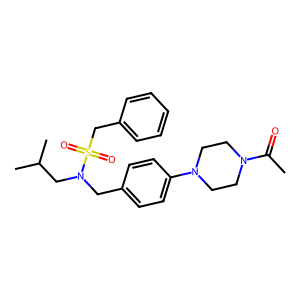

In [34]:
seed_ligand = "CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(C)=O)[S](=O)(=O)Cc3ccccc3"
seed_mol = dm.to_mol(seed_ligand)
display(dm.to_image(seed_mol))

### Create modified SMILES, with "Fe" as exploration point on `SEED`

Ligand drawn with https://molview.org/ and exported as canonical SMILES string.

Set the exploration point at "Fe" so it is easy to find and edit in the resulting SMILES.


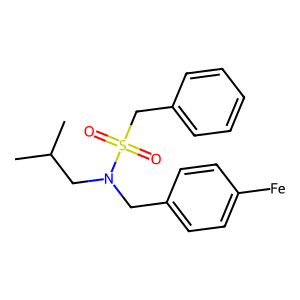

In [35]:
testsmiles = "CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2"
testmol = dm.to_mol(testsmiles)
display(dm.to_image(testmol))

In [36]:
safe_str = sf.encode(testmol)
print(f"SMILES: {testsmiles}")
print(f"SAFE:   {safe_str}\n represented using {len(safe_str.split('.'))} fragments")

SMILES: CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2
SAFE:   c15cc[c]([Fe])cc1.c16ccccc1.S4(=O)(=O)C6.CC(C)C2.N234.C35
 represented using 6 fragments


### Ensure `safe` and `datamol` are functioning correctly

Reconstruct the fragments to ensure reconstruction matches original input

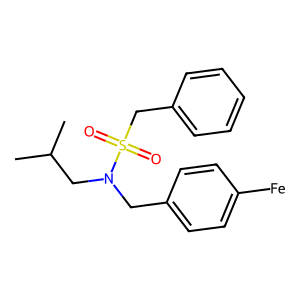

In [37]:
testreconstructed = dm.to_mol(safe_str)
display(dm.to_image(testreconstructed))

### Visualize `safe` deconstruction of SMILES into fragments

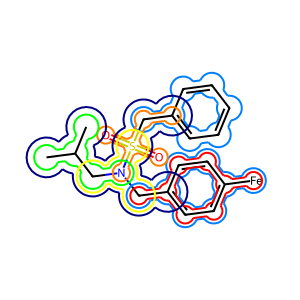

In [38]:
sf.to_image(safe_str)

### Edit SMILES of parent ligand to enable `GenMol`

Replace `[Fe]` in SMILES string with `[2*]`

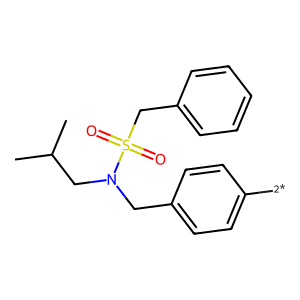

In [39]:
smiles = 'CC(C)CN(Cc1ccc([2*])cc1)[S](=O)(=O)Cc2ccccc2'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [40]:
safe = Utils.smiles2safe(smiles)
safe

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57'

### Create the `safe` SMILES with the generation/edit point included

In [41]:
smiles = safe + '.[*{15-35}]'
smiles

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57.[*{15-35}]'

## 2.3 Configure the `GenMol` API

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [42]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/genmol/generate"

session = requests.Session()

## 2.4 Connect to the `GenMol` API and collect the results

In [43]:
payload = {
    "smiles": smiles,
    "num_molecules": 100,
    "temperature": 2,
    "noise": 0.5,
    "step_size": 1,
    "scoring": "QED"
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=payload)

response.raise_for_status()
result = response.json()
print(result)

{'status': 'success', 'molecules': [{'smiles': 'CC(C)CN(Cc1ccc(N)cc1)S(=O)(=O)Cc1ccccc1', 'score': 0.792}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles'

### Determine similarities between `SEED` and generated ligands

In [44]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [47]:
unique_molecules = {mol['smiles']: mol['score'] for mol in result['molecules']}
smiles_list = list(unique_molecules.keys())
qed_list = list(unique_molecules.values())
qed_list = [round(_, 2) for _ in qed_list]

# Calculate Tanimoto similarity for each SMILES
tanimoto_sim_list = []

for smile in smiles_list:
  tanimoto = round(tanimoto_similarity(smile, seed_ligand), 2)
  tanimoto_sim_list.append(tanimoto)

[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerator
[22:56:29] DEPRECATION WARNING: please use MorganGenerat

In [48]:
df_viz = pd.DataFrame({
    'smiles': smiles_list,
    'tanimoto': tanimoto_sim_list,
    'qed': qed_list,
})
df_viz = df_viz.sort_values(
    by=['tanimoto', 'qed'],
    ascending=[False, False])
df_viz.head()

,smiles,tanimoto,qed
9,CC(C)CN(Cc1ccc(N2CCCCC2)cc1)S(=O)(=O)Cc1ccccc1,0.75,0.65
8,CC(=O)c1ccc(CN(CC(C)C)S(=O)(=O)Cc2ccccc2)cc1,0.64,0.67
1,CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1,0.62,0.78
15,CC(C)CN(Cc1ccc(Cc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1,0.61,0.48
13,CC(C)CN(Cc1ccc(-c2ccccc2)cc1)S(=O)(=O)Cc1ccccc1,0.60,0.52


### Visualize the results

**Note:** only keeping the unique results, duplicates are omitted

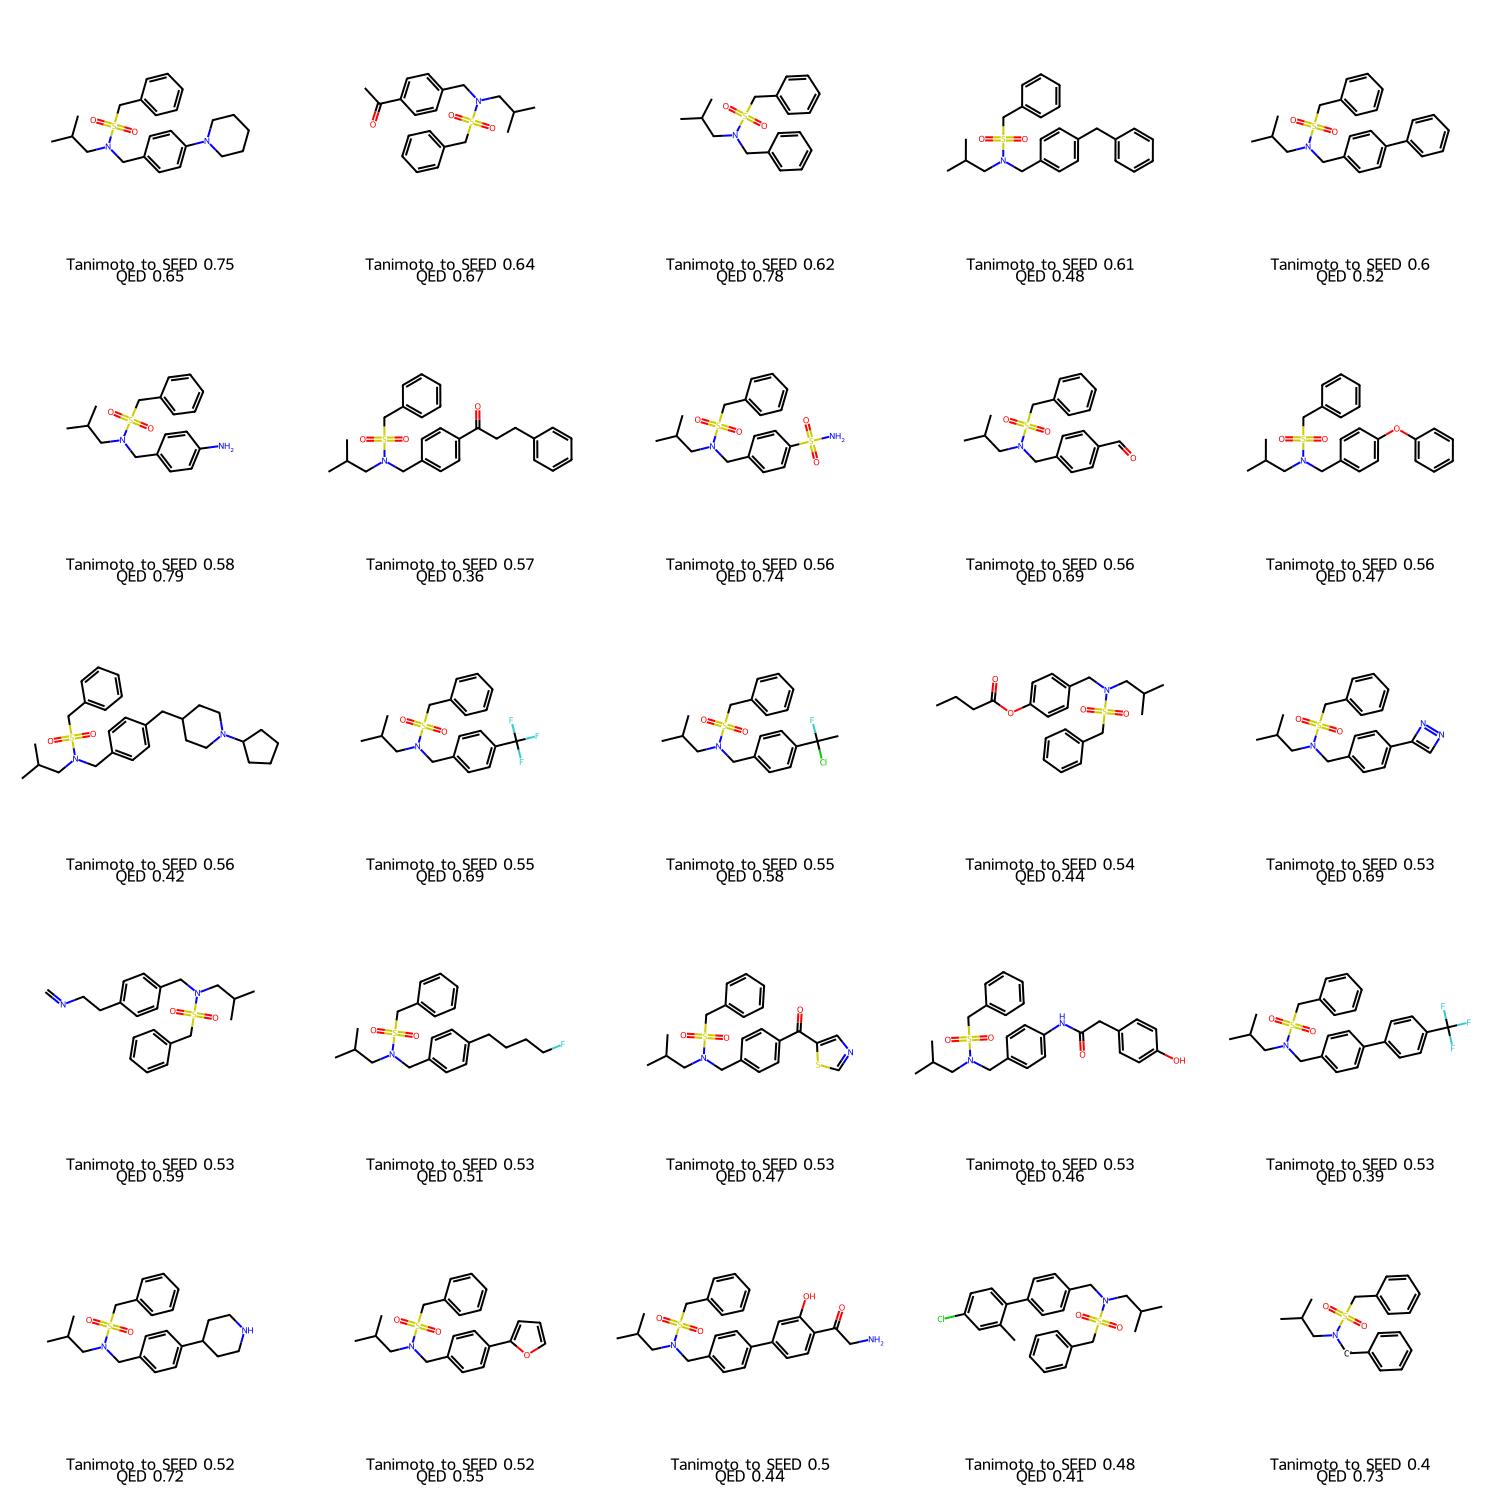

In [51]:
df_smiles = df_viz["smiles"].tolist()
df_tanimoto = df_viz["tanimoto"].tolist()
df_qed = df_viz["qed"].tolist()
ms = [Chem.MolFromSmiles(_) for _ in df_smiles]
dopts = Draw.MolDrawOptions()
dopts.legendFontSize=16
dopts.legendFraction=0.2
Draw.MolsToGridImage(ms,
                     molsPerRow=5,
                     subImgSize=(300, 300),
                     legends = [f"Tanimoto to SEED {tanimoto}\nQED {qed}" for tanimoto, qed in zip(df_tanimoto, df_qed)],
                     drawOptions=dopts,
                     )

## 2.5 Preprocess the Generated Small Molecules for use in `DiffDock`

In [52]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 5 for now.
N_molecules_for_docking = 5

# choose the first N molecules
# list is prioritized by highest Tanimoto similarity, highest MinSim, highest QED
molecules = df_smiles[:N_molecules_for_docking]

print(molecules)

['CC(C)CN(Cc1ccc(N2CCCCC2)cc1)S(=O)(=O)Cc1ccccc1', 'CC(=O)c1ccc(CN(CC(C)C)S(=O)(=O)Cc2ccccc2)cc1', 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccc(Cc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1', 'CC(C)CN(Cc1ccc(-c2ccccc2)cc1)S(=O)(=O)Cc1ccccc1']


In [53]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

Convert SMILES to SDF (generate 1 conformer for each SMILES)

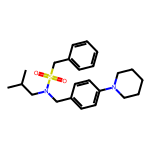

Converted SMILES to SDF: CC(C)CN(Cc1ccc(N2CCCCC2)cc1)S(=O)(=O)Cc1ccccc1


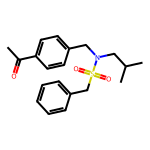

Converted SMILES to SDF: CC(=O)c1ccc(CN(CC(C)C)S(=O)(=O)Cc2ccccc2)cc1


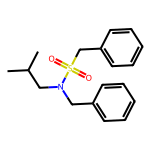

Converted SMILES to SDF: CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1


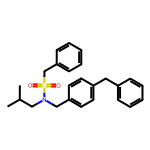

Converted SMILES to SDF: CC(C)CN(Cc1ccc(Cc2ccccc2)cc1)S(=O)(=O)Cc1ccccc1


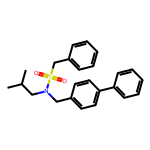

Converted SMILES to SDF: CC(C)CN(Cc1ccc(-c2ccccc2)cc1)S(=O)(=O)Cc1ccccc1
['/content/output/genmol_result/clean_mols/molecule_0.sdf', '/content/output/genmol_result/clean_mols/molecule_1.sdf', '/content/output/genmol_result/clean_mols/molecule_2.sdf', '/content/output/genmol_result/clean_mols/molecule_3.sdf', '/content/output/genmol_result/clean_mols/molecule_4.sdf']


In [55]:
output_dir = "/content/output/genmol_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol_2d = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol_2d)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    img = Draw.MolToImage(mol_2d, size=(150, 150))
    display(img)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

### Download SDF files which need to be uploaded in Step 3 - Using DiffDock to Predict Docking Poses

In [56]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

  adding: molecule_4.sdf (deflated 79%)
  adding: molecule_0.sdf (deflated 79%)
  adding: molecule_3.sdf (deflated 78%)
  adding: molecule_2.sdf (deflated 79%)
  adding: molecule_1.sdf (deflated 79%)


In [57]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>